In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

In [35]:
df_list = []
for i in range(1,29):
    temp_df = pd.read_csv('results/summer/'+str(i)+'_out.csv', index_col=0)
    temp_df.index = pd.to_datetime(temp_df.index)
    df_list.append(temp_df)

In [36]:
df_list[0].keys()

Index(['heating setpoint', 'cooling setpoint', 'Whole Building Electricity',
       'Site Outdoor Air Temperature',
       'furnace airloop Discharge Air Flow Sensor',
       'furnace airloop Discharge Air Temp Sensor',
       'living space Air Temperature', 'living space Humidity',
       'living space Temperature Setpoint',
       'furnace airloop ret air zone Air Temperature',
       'furnace airloop ret air zone Humidity',
       'crawlspace - unvented Air Temperature',
       'crawlspace - unvented Humidity', 'attic - vented Air Temperature',
       'attic - vented Humidity', 'Heating:Electricity',
       'WaterSystems:Electricity', 'Fans:Electricity',
       'InteriorEquipment:Electricity', 'Electricity:HVAC'],
      dtype='object')

In [37]:
building = 3

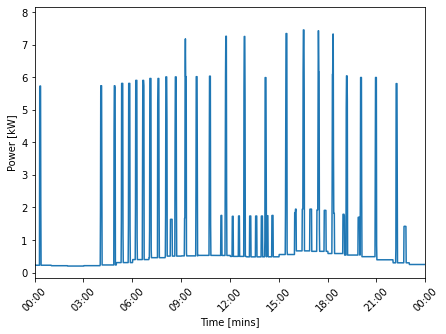

In [62]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Whole Building Electricity'])

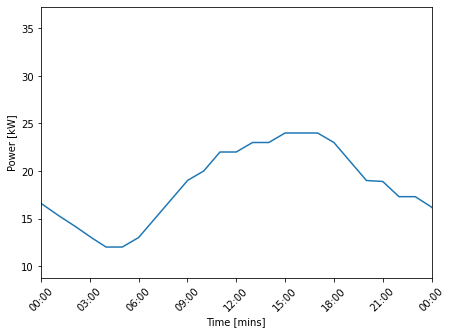

In [52]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Site Outdoor Air Temperature'])

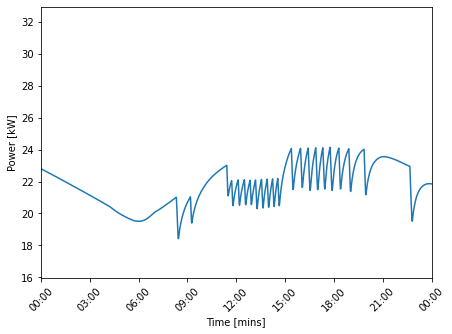

In [53]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['living space Air Temperature'])

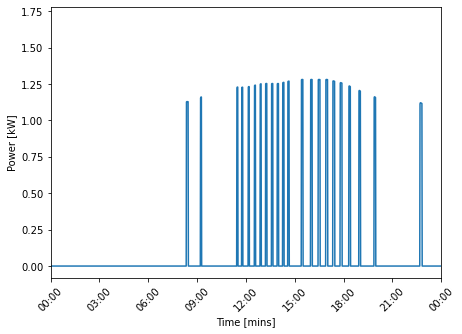

In [60]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Electricity:HVAC'])

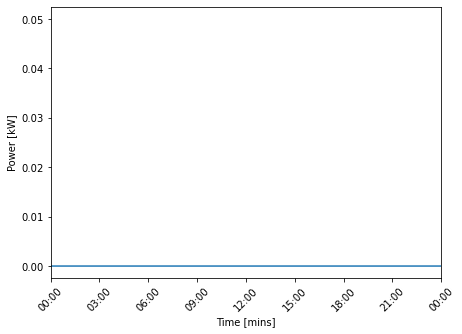

In [54]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Heating:Electricity'])

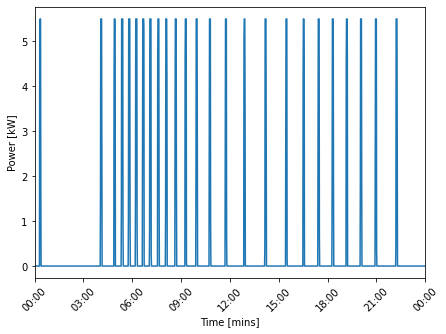

In [55]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['WaterSystems:Electricity'])

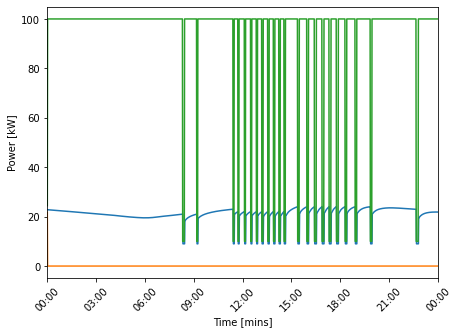

In [56]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['living space Temperature Setpoint'])
ax.plot(df_list[building].index, df_list[building]['heating setpoint'])
ax.plot(df_list[building].index, df_list[building]['cooling setpoint'])

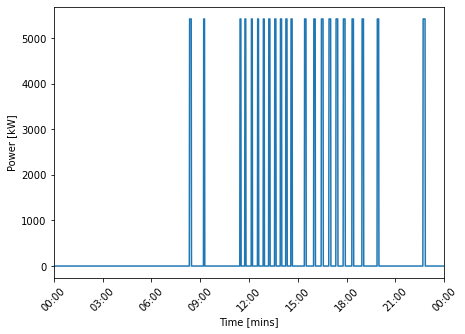

In [57]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Fans:Electricity'])

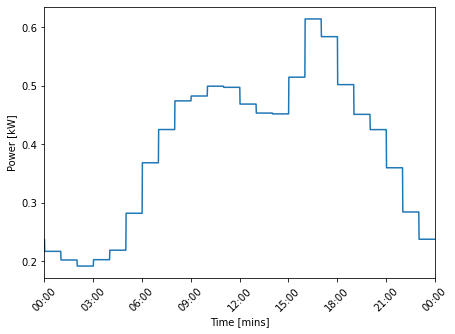

In [59]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['InteriorEquipment:Electricity'] * 1e-3 / 60)

In [47]:
df_aggregate = pd.read_csv('results/aggregate_out.csv')

Text(0, 0.5, 'Whole Building Electricity')

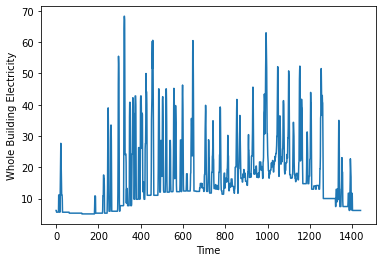

In [48]:
plt.figure()
plt.plot(df_aggregate['0'])
plt.xlabel("Time")
plt.ylabel('Whole Building Electricity')

KeyError: 'Predicted Temperature'

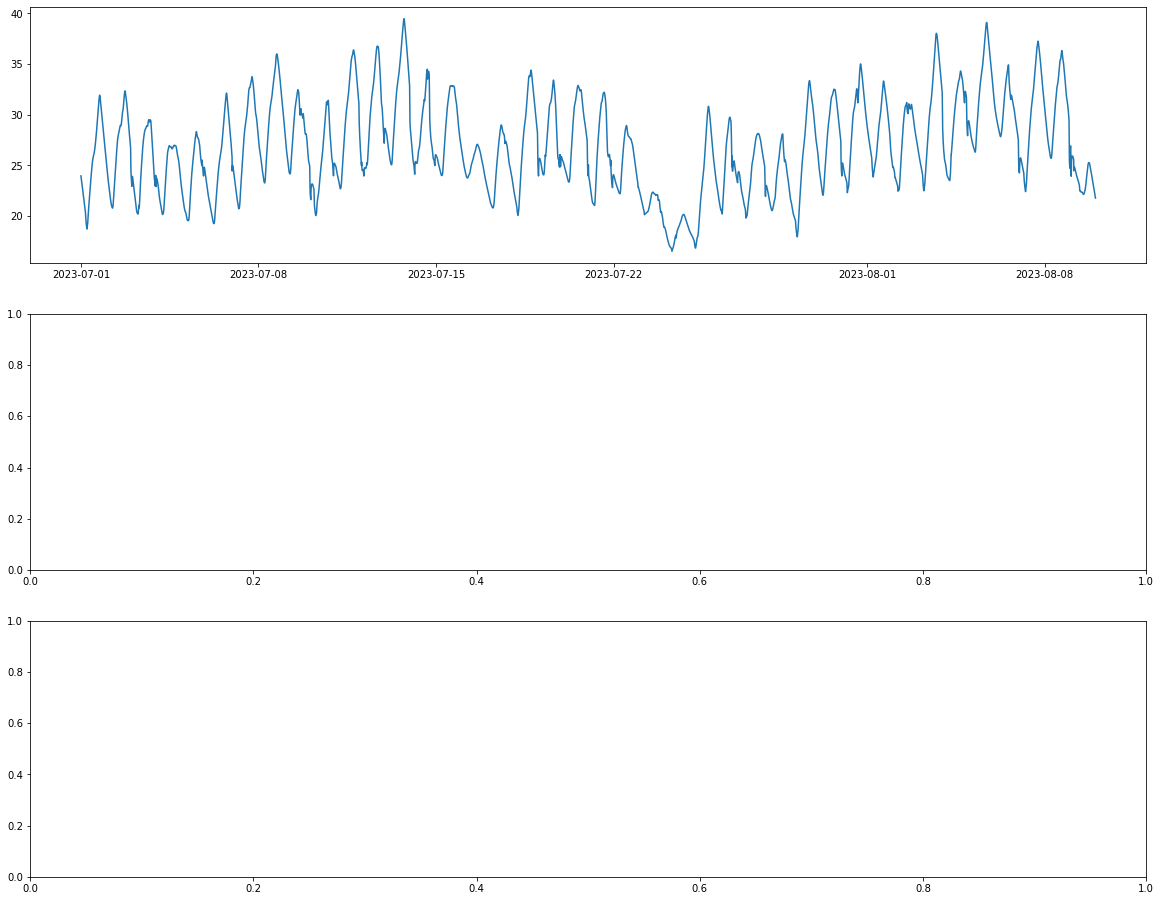

In [49]:
fig, ax = plt.subplots(3,figsize=(20,16))
# for i in range(0,len(df_list)):
i = 0
ax[0].plot(df_list[i]['living space Air Temperature'], label='True temp')
ax[0].plot(df_list[i]['Predicted Temperature'], label='Pred temp')
ax[0].plot(df_list[i]['Ymax'], '--', linewidth=3, c='k')
ax[0].plot(df_list[i]['Ymin'], '--', linewidth=3, c='k')
ax[0].set_ylabel('y', fontsize=26)
ax[0].grid(True)
ax[0].tick_params(axis='x', labelsize=26)
ax[0].tick_params(axis='y', labelsize=26)
# ax[0].set_xlim(0, 1440)
ax[1].plot(df_list[i]['Control Effort'])
ax[1].plot(df_list[i]['Heating:Electricity'])
ax[1].set_ylabel('u', fontsize=26)
ax[1].grid(True)
ax[1].tick_params(axis='x', labelsize=26)
ax[1].tick_params(axis='y', labelsize=26)
# ax[1].set_xlim(0, 1440)
ax[1].set_ylim(-0.1,1.6)
ax[2].plot(df_list[i]['Site Outdoor Air Temperature'])
ax[2].set_ylabel('d', fontsize=26)
ax[2].grid(True)
ax[2].tick_params(axis='x', labelsize=26)
ax[2].tick_params(axis='y', labelsize=26)
# ax[2].set_xlim(0, 1440)
ax[2].set_xlabel('Time [mins]', fontsize=26)
fig.patch.set_facecolor('white')